In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data

In [2]:
train_data = pd.read_csv("train.csv", index_col = 'Id')
test_data = pd.read_csv("test.csv", index_col = "Id")

X_train = train_data.drop(['SalePrice'], axis = 1)
y = train_data['SalePrice']

X = pd.concat([X_train, test_data], axis = 0)

In [3]:
print(X_train.shape)
print(test_data.shape)

(1460, 79)
(1459, 79)


In [4]:
numCols = list(X_train.select_dtypes(exclude='object').columns)
catCols = list(X_train.select_dtypes(include='object').columns)

In [5]:
print(numCols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [6]:
print(catCols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# Exploratory Data Analysis

### Target Variable

We want to take a look at the distribution of our target variable.

We find out that it is right-skewed. 

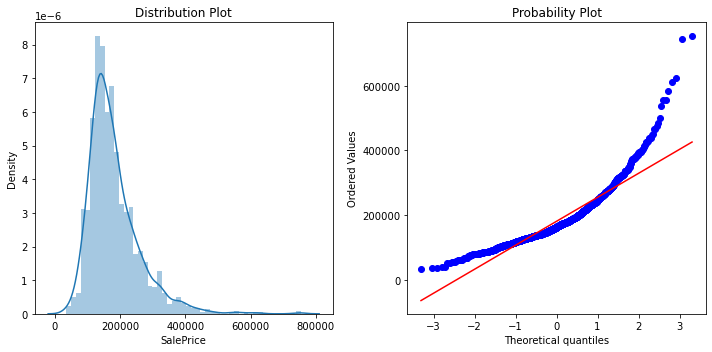

In [7]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.distplot(y, ax=axes[0])
axes[0].set_title('Distribution Plot')

axes[1] = stats.probplot((y), plot=plt)
plt.tight_layout()

#### Log Transformation

Log transformation shows more normal distribution, so this will be our target variable.

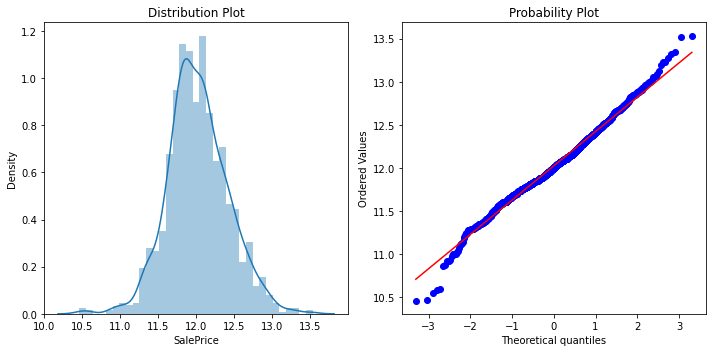

In [37]:
y = np.log(y)
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.distplot(y, ax=axes[0])
axes[0].set_title('Distribution Plot')

axes[1] = stats.probplot((y), plot=plt)
plt.tight_layout()

### Numerical Variables

Finding numerical variables most correlated with SalePrice.

Notice TotalBsmtSF and 1stFlrSF. Could these be combined? 
Does TotRmsAbvGrd correlate with those two variables as well?

In [8]:
corr_matrix = train_data.corr().SalePrice.sort_values(ascending = False)
corr_matrix.head(11)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

sklearn has a feature called Recursive Feature Elimination which will give us rankings of the top features. 

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10, step=1)
selector = rfe.fit(X_train.fillna(0).select_dtypes(exclude='object'), y)
selectedFeatures = list(
    X.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures

['OverallQual',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

We still haven't done a lot of data cleaning, so by no means is this accurate for our final model, but it should give us an idea moving forward. We can see how these top 10 variables look against our target variable. 

Also notice these 4 variables: BsmtFullBath, BsmtHalfBath, FullBath, HalfBath. Could they be combined?

#### OverallQual

Overall Quality has the highest correlation, as well as the most weight (based on RFE).

Intuitively, it makes sense that the higher quality house will have a higher price.

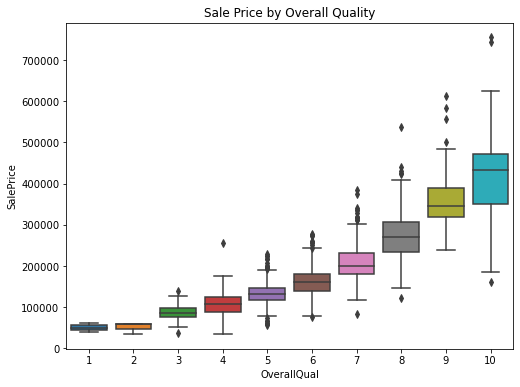

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Overall Quality')

#### GrLivArea

We can see the linear relationship between Above Ground Living Area and Sale Price, but has a few outliers (two houses in lower-right corner)

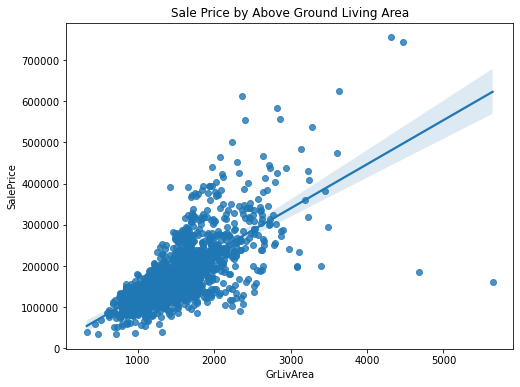

In [11]:
plt.figure(figsize=(8, 6))
sns.regplot(x= 'GrLivArea', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Above Ground Living Area')

#### GarageCars

Houses with 4 car garages are cheaper than houses with only 3 car garages. 

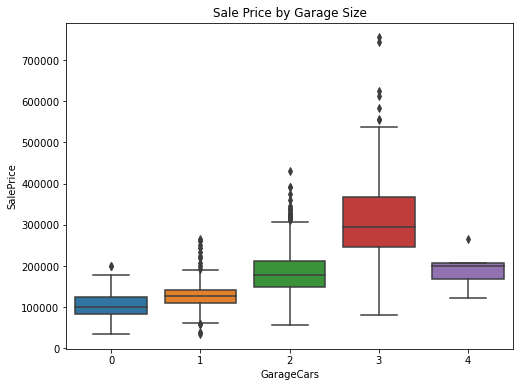

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Garage Size')

#### YearBuilt

Generally speaking, newer houses have higher Sale Prices, however, there are a few outliers.

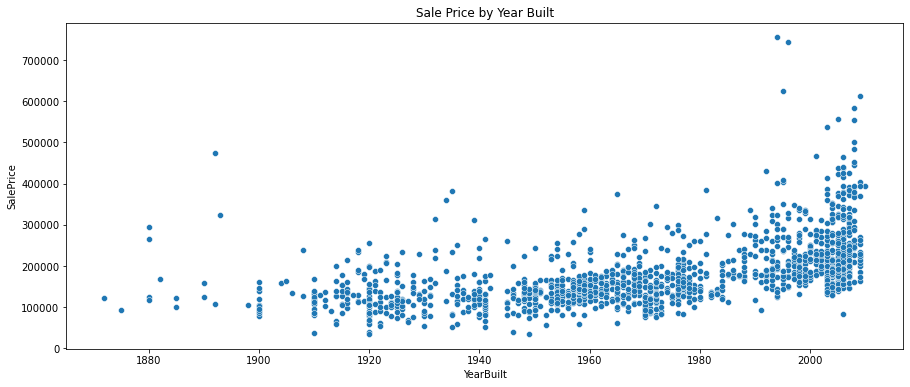

In [13]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Year Built')

### Categorical Variables

In [14]:
print(catCols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


#### Ordinal Variables

In [15]:
ordinal_cols = ['LotShape', 'LandSlope', 'ExterQual',
               'ExterCond','BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'HeatingQC','CentralAir', 'KitchenQual',
               'Functional','FireplaceQu', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'PavedDrive', 
               'Fence', 'PoolQC']

#### Nominal Variables

In [16]:
nominal_cols = ['MSSubClass', 'MSZoning', 'LandContour',
                  'LotConfig', 'Neighborhood', 'BldgType',
                  'HouseStyle', 'RoofStyle', 'MasVnrType',
                  'Foundation', 'GarageType', 'SaleType',
                  'SaleCondition', 'Condition1','Exterior1st',
                  'Exterior2nd', 'MiscFeature', 'Alley', 'Utilities', 
                'Electrical',]

# Correlation

We can see that there is multicollinearity in our dataset.

- GarageYrBlt and YearBuilt
- 1stFlrSF and 2ndFlrSF
- TotRmsAbvGrd and GrLivArea
- GarageArea and GarageCars
- GrLivArea and 2ndFlrSF

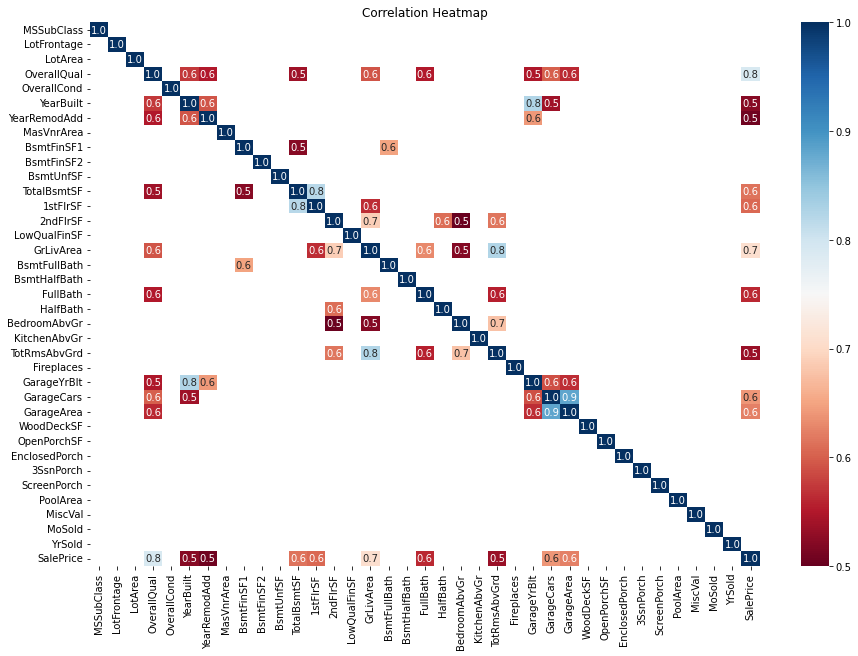

In [17]:
corr_mat = train_data.corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='RdBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

# Feature Engineering

If we take a look at the data description, "NA" means the feature doens't exist rather than a "missing value." So we will replace "NA" in categorical features to "None" whenever it is not a true null. Then impute the remaining missing values

- Numerical features: use sample median to account for outliers as well as for discrete variables. (Only two variables: Lot Frontage and MasVnrArea)
- Ordinal features: use sample mode
- Nominal features: use sample mode

We then have to encode categorical variables.
- Ordinal: Label Encoding
- Nominal: One-hot Encoding (Dummy Variables)

From our correlation matrix, as well as our earlier theories, we should create new variables.

- totalSqFt = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
- totalBath = FullBath + BsmtFullBath + 0.5(HalfBath + BsmtHalfBath)


### Missing Values

In [18]:
missing_data_count = X.isnull().sum()
missing_data = pd.DataFrame({
    'Count': missing_data_count,
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

In [19]:
missing_data.head(10)

,Count
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageCond,159
GarageYrBlt,159


#### Ordinal Variables

In [20]:
for feature in ordinal_cols:
    X[feature] = X[feature].fillna("None")

#### Nominal Variables

In [21]:
for feature in nominal_cols:
    X[feature] = X[feature].fillna("None")

#### Nominal Variables.2

Although NA means None, we need to represent these variables specifically with 0 since we will be combining them to make a new variable.

In [22]:
special_nom_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'CentralAir']

for feature in special_nom_cols:
    X[feature] = X[feature].fillna(0)

#### Numerical Variables

#### Lot Frontage

Impute LotFrontage with the median of the neighborhood it's in.

In [23]:
neighborhood_medians = X.groupby('Neighborhood')['LotFrontage'].median()
neighborhood_medians = neighborhood_medians.fillna(np.median(neighborhood_medians))

In [24]:
X['LotFrontage'] = X['LotFrontage'].fillna(X['Neighborhood'])
X['LotFrontage'] = X['LotFrontage'].map(lambda x: neighborhood_medians[x] if type(x)==str else x)


In [25]:
X['LotFrontage'].isna().sum()

0

#### Masonry

In [26]:
MasVnrArea_Median = X['MasVnrArea'].median()
X['MasVnrArea'].fillna(MasVnrArea_Median, inplace = True)

In [27]:
X['MasVnrArea'].isna().sum()

0

#### GarageYrBuilt


In [28]:
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])

In [29]:
X['GarageYrBlt'].isna().sum()

0

In [30]:
missing_num_list = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                    'TotalBsmtSF', 'GarageCars', 'GarageArea']

for feature in missing_num_list:
    X[feature] = X[feature].fillna(X[feature].median())

Check if there are any missing values left.

In [31]:
sum(X.isnull().sum())

0

### Creating New Variables

Creating new variables totalSqFeet and totalBath

In [32]:
X['totalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['totalBath'] = X['FullBath'] + X['BsmtFullBath'] + 0.5 * (X['HalfBath'] + X['BsmtHalfBath'])


### Label Encoding

Ordinal Variables are Label Encoded

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for feature in ordinal_cols:
    X[feature] = label_encoder.fit_transform(X[feature])

### One-hot Encoding

In [35]:
X = pd.get_dummies(X, drop_first=True)

X.shape: (2919, 210)


# Modeling

Regularized Regression:
- Ridge
- Lasso
- Elastic Net

Non-linear:
- Random Forest
- XGBoost
- LightGBM


### RSME Function

The goal is to find a model that minimizes RSME. Our target variable will be log of Sale Price.




In [39]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5


def getRMSE(model):
    """
    Return the average RMSE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=0)

    # Get RMSE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

In [41]:
from sklearn.linear_model import Ridge, Lasso

#### Ridge Regression



/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py", line 542, in fit
    X, y = self._validate_data(X, y,
  File "/Users/thomasouyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thomasouyang/opt/anaconda3/lib/

Best lambda: nan
RMSE: nan


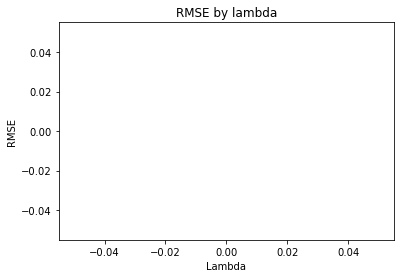

In [43]:
lambda_list = list(np.linspace(20, 25, 101))

rmse_ridge = [getRMSE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmse_ridge = pd.Series(rmse_ridge, index=lambda_list)

rmse_ridge.plot(title="RMSE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

print("Best lambda:", rmse_ridge.idxmin())
print("RMSE:", rmse_ridge.min())

